In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
from IPython.display import HTML
from torch.nn import functional as F
import sys

np.set_printoptions(threshold=50, edgeitems=20)

PATH='./data/processed/'

In [3]:
sys.path.append('../../Fast.ai/fastai')

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
%time train = pd.read_csv('./data/processed/train.csv',parse_dates=['click_time'], nrows=3000000)
%time test = pd.read_csv('./data/processed/test.csv',parse_dates=['click_time'], nrows=100000)

CPU times: user 3.26 s, sys: 241 ms, total: 3.5 s
Wall time: 3.5 s
CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 110 ms


In [7]:
len(train),len(test)

(3000000, 100000)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 12 columns):
ip               int64
app              int64
device           int64
os               int64
channel          int64
click_time       datetime64[ns]
is_attributed    int64
hour             int64
ip_time_diff     float64
all_time_diff    float64
ip_count         int64
all_count        int64
dtypes: datetime64[ns](1), float64(2), int64(9)
memory usage: 274.7 MB


In [9]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,ip_time_diff,all_time_diff,ip_count,all_count
0,1,1,1,2,125,2017-11-09 14:34:10,0,14,1.0,-1.0,47,1
1,1,1,1,9,125,2017-11-09 03:01:54,0,3,0.0,44864.0,47,1
2,1,1,1,48,13,2017-11-09 10:42:11,0,10,465.0,-1.0,47,1
3,1,2,1,2,477,2017-11-08 17:47:39,0,17,1323.0,-1.0,47,5
4,1,2,1,2,477,2017-11-08 20:08:39,0,20,177.0,8460.0,47,5


In [10]:
test.head()

,click_id,ip,app,device,os,channel,click_time,hour,ip_time_diff,all_time_diff,ip_count,all_count
0,2890381,0,0,0,0,101,2017-11-10 04:51:27,4,-1.0,-1.0,2,2
1,3036280,0,0,0,0,101,2017-11-10 04:54:10,4,163.0,163.0,2,2
2,3055961,1,10,1,7,113,2017-11-10 04:54:32,4,-1.0,-1.0,1,1
3,12491273,2,1,1,13,371,2017-11-10 13:03:16,13,0.0,-1.0,5,1
4,12491143,2,3,1,13,371,2017-11-10 13:03:16,13,1.0,0.0,5,1


In [11]:
train.drop(['click_time'], axis=1, inplace=True)
test.drop(['click_time'], axis=1, inplace=True)

In [12]:
cat_vars = ['ip', 'app', 'device', 'os', 'channel', 'hour']

contin_vars = ['ip_time_diff', 'all_time_diff', 'ip_count', 'all_count']

label = 'is_attributed'

n = len(train); n

3000000

In [13]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

apply_cats(test, train)

In [14]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

In [15]:
test[label] = 0
#train[label] = train[label].astype('category').cat.as_ordered()

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 11 columns):
ip               category
app              category
device           category
os               category
channel          category
is_attributed    int64
hour             category
ip_time_diff     float32
all_time_diff    float32
ip_count         float32
all_count        float32
dtypes: category(6), float32(4), int64(1)
memory usage: 100.2 MB


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
click_id         100000 non-null int64
ip               88689 non-null category
app              99969 non-null category
device           99395 non-null category
os               99097 non-null category
channel          99973 non-null category
hour             100000 non-null category
ip_time_diff     100000 non-null float32
all_time_diff    100000 non-null float32
ip_count         100000 non-null float32
all_count        100000 non-null float32
is_attributed    100000 non-null int64
dtypes: category(6), float32(4), int64(2)
memory usage: 4.2 MB


In [18]:
df, y, nas, mapper = proc_df(train, label, do_scale=True)
df_test, _, nas, mapper = proc_df(test, label, do_scale=True, mapper=mapper, na_dict=nas, skip_flds=['click_id'])

In [19]:
df.head()

,ip,app,device,os,channel,hour,ip_time_diff,all_time_diff,ip_count,all_count
0,1,2,2,3,30,15,-0.149083,-0.543647,-1.031648,-0.389339
1,1,2,2,10,30,4,-0.152020,1.772797,-1.031648,-0.389339
2,1,2,2,48,5,11,1.213541,-0.543647,-1.031648,-0.389339
3,1,3,2,3,157,18,3.733220,-0.543647,-1.031648,-0.334801
4,1,3,2,3,157,21,0.367774,-0.106794,-1.031648,-0.334801


In [20]:
df_test.head()

,ip,app,device,os,channel,hour,ip_time_diff,all_time_diff,ip_count,all_count
0,0,1,1,1,14,5,-0.154956,-0.543647,-1.035773,-0.375704
1,0,1,1,1,14,5,0.326661,-0.535180,-1.035773,-0.375704
2,1,11,2,8,20,5,-0.154956,-0.543647,-1.035865,-0.389339
3,0,2,2,14,110,14,-0.152020,-0.543647,-1.035498,-0.389339
4,0,4,2,14,110,14,-0.149083,-0.543596,-1.035498,-0.389339


In [21]:
train_ratio = 0.8
train_size = int(n * train_ratio)
val_idx = list(range(train_size, len(df)))
trn_idx = list(range(0, train_size))

## Modifications for binary classifier

In [22]:
import numbers
import numpy as np
import torch


class AUCMeter():
    """
    The AUCMeter measures the area under the receiver-operating characteristic
    (ROC) curve for binary classification problems. The area under the curve (AUC)
    can be interpreted as the probability that, given a randomly selected positive
    example and a randomly selected negative example, the positive example is
    assigned a higher score by the classification model than the negative example.
    The AUCMeter is designed to operate on one-dimensional Tensors `output`
    and `target`, where (1) the `output` contains model output scores that ought to
    be higher when the model is more convinced that the example should be positively
    labeled, and smaller when the model believes the example should be negatively
    labeled (for instance, the output of a signoid function); and (2) the `target`
    contains only values 0 (for negative examples) and 1 (for positive examples).
    """

    def __init__(self):
        super(AUCMeter, self).__init__()
        self.reset()

    def reset(self):
        self.scores = torch.DoubleTensor(torch.DoubleStorage()).numpy()
        self.targets = torch.LongTensor(torch.LongStorage()).numpy()

    def add(self, output, target):
        if torch.is_tensor(output):
            output = output.cpu().squeeze().numpy()
        if torch.is_tensor(target):
            target = target.cpu().squeeze().numpy()
        elif isinstance(target, numbers.Number):
            target = np.asarray([target])
        assert np.ndim(output) == 1, \
            'wrong output size (1D expected)'
        assert np.ndim(target) == 1, \
            'wrong target size (1D expected)'
        assert output.shape[0] == target.shape[0], \
            'number of outputs and targets does not match'
        assert np.all(np.add(np.equal(target, 1), np.equal(target, 0))), \
            'targets should be binary (0, 1)'

        self.scores = np.append(self.scores, output)
        self.targets = np.append(self.targets, target)

    def value(self):
        # case when number of elements added are 0
        if self.scores.shape[0] == 0:
            return 0.5

        # sorting the arrays
        scores, sortind = torch.sort(torch.from_numpy(
            self.scores), dim=0, descending=True)
        scores = scores.numpy()
        sortind = sortind.numpy()

        # creating the roc curve
        tpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)
        fpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)

        for i in range(1, scores.size + 1):
            if self.targets[sortind[i - 1]] == 1:
                tpr[i] = tpr[i - 1] + 1
                fpr[i] = fpr[i - 1]
            else:
                tpr[i] = tpr[i - 1]
                fpr[i] = fpr[i - 1] + 1

        tpr /= (self.targets.sum() * 1.0)
        fpr /= ((self.targets - 1.0).sum() * -1.0)

        # calculating area under curve using trapezoidal rule
        n = tpr.shape[0]
        h = fpr[1:n] - fpr[0:n - 1]
        sum_h = np.zeros(fpr.shape)
        sum_h[0:n - 1] = h
        sum_h[1:n] += h
        area = (sum_h * tpr).sum() / 2.0

        return (area, tpr, fpr)

In [23]:
def roc(y_pred, targ):
    y_pred = y_pred.round()
    auc = AUCMeter()
    auc.add(y_pred, targ)
    area, tpr, fpr = auc.value()
    
    return area

In [24]:
from sklearn.metrics import fbeta_score

def f2(preds,targs,start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples') for th in np.arange(start,end,step)])

In [25]:
from sklearn.metrics import roc_auc_score

def roc_auc(preds,targs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max(roc_auc_score(targs, (preds>0.5), average='macro'),0)

In [26]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x

In [27]:
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y.values # THIS LINE IS CHANGED FROM y[:, None]
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y)

In [28]:
class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

## Training NN

In [29]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

In [30]:
cat_sz

[('ip', 906),
 ('app', 308),
 ('device', 581),
 ('os', 223),
 ('channel', 173),
 ('hour', 25)]

In [31]:
emb_szs = [(c, min(1000, c)) for _,c in cat_sz]

In [32]:
emb_szs

[(906, 906), (308, 308), (581, 581), (223, 223), (173, 173), (25, 25)]

In [33]:
model = MixedInputModel(emb_szs, n_cont=len(contin_vars), emb_drop=0.05, out_sz=2, \
                        szs=[1000,500], drops=[0.001,0.01], y_range=(0, 1)).cuda()

In [34]:
bm = BasicModel(model, 'binary_classifier')

In [35]:
y = pd.DataFrame(y, dtype='int')

In [36]:
trn_df, trn_y = df.iloc[trn_idx], y[y.columns[0]].iloc[trn_idx] 
val_df, val_y = df.iloc[val_idx], y[y.columns[0]].iloc[val_idx]

In [37]:
md = ColumnarModelData.from_data_frames('/tmp', trn_df, val_df, trn_y.astype('category'), \
                                        val_y.astype('category'), cat_flds=cat_vars, bs=1024, test_df=df_test)

In [38]:
# you can simply create learner with any custom model and data
# source code is here
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss


learn = StructuredLearner(md, bm)

In [39]:
# note that we've changed the model class' crit attribute
# this is not recommended from an OOP perspective 
# but it's handy here
learn.crit = F.cross_entropy
learn.crit

<function torch.nn.functional.cross_entropy>

In [40]:
learn.lr_find()

epoch      trn_loss   val_loss                                 
    0      0.314576   0.31422   



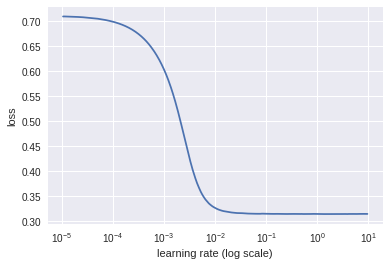

In [41]:
%matplotlib inline
learn.sched.plot()

In [46]:
lr = 5*1e-2
learn.fit(lr, 2)

  4%|▍         | 89/2344 [00:03<01:03, 35.58it/s, loss=0.315]
epoch      trn_loss   val_loss                                 
    0      0.314471   0.314222  
    1      0.314502   0.314222                                 



[0.31422168]

## Test

In [47]:
preds = learn.predict_dl(md.test_dl)

In [48]:
preds[0:10]

array([[ 0.99989,  0.00011],
       [ 0.99988,  0.00012],
       [ 1.     ,  0.     ],
       [ 1.     ,  0.     ],
       [ 1.     ,  0.     ],
       [ 1.     ,  0.     ],
       [ 1.     ,  0.     ],
       [ 1.     ,  0.     ],
       [ 1.     ,  0.     ],
       [ 1.     ,  0.     ]], dtype=float32)

In [49]:
max(preds[:,1])

0.00036045615

In [50]:
np.mean(preds[:,1])

7.6834658e-06

In [51]:
# softmax
expsums = np.exp(preds).sum(axis=1)
probs = np.exp(preds) / expsums[:, None]

In [52]:
max(probs[:,1])

0.26908532

In [53]:
min(probs[:,1])

0.26894143

In [54]:
sub = pd.DataFrame({'click_id':test.click_id, 'is_attributed':probs[:, 1]})[['click_id', 'is_attributed']]

In [55]:
sub.head()

,click_id,is_attributed
0,2890381,0.268983
1,3036280,0.268987
2,3055961,0.268942
3,12491273,0.268942
4,12491143,0.268942


In [56]:
sub.describe()

,click_id,is_attributed
count,1.000000e+05,100000.000000
mean,9.508937e+06,0.269076
std,5.425972e+06,0.000132
min,2.170000e+02,0.268941
25%,4.861234e+06,0.268942
50%,9.461924e+06,0.268942
75%,1.424712e+07,0.268942
max,1.879033e+07,0.269085


In [57]:
sub.to_csv('baseline_submission.csv', index=False)